# **Infer `Cellmask` and `Nucleus`**

***Prior to this notebook, you should have already run through [1.0_image_setup](1.0_image_setup.ipynb).***

***⚠️ Sample data is not yet applicable to this notebook. If you wish to use the sample data, please begin on notebooks [1.1a](./1.1a_infer_masks_from-composite_single_cell.ipynb), [1.1b](./1.1b_infer_masks_from-composite_multiple-cells.ipynb), [1.1c](./1.1c_infer_masks_from-composite_neuron_with_pm.ipynb) or [1.1d](./1.1d_infer_masks_from-composite_iPSC.ipynb). ⚠️***

### ➡️ **Input:**
In this workflow, a single or multi-channel confocal microscopy image of fluorescently tagged organelles will be used to "infer" (or segment) the cell and nucleus masks. The following setup is recommended for this pipeline:

| **Imaging Requirements**|[**Masks Workflow**](./1.1_infer_masks_from-composite_with_nuc.ipynb)|
| :------------------------------------- |  :------:  |
| Nuclei Marker                          |     ✔     |
| Cell Membrane Marker                   |     ✘     |
| Cytoplasmic Organelles                 |     ✔     |
| Number of cells per image              |  Single or Multiple  |
| Applicable with sample data         |  ✘  |

*If your images are not compatible with this setup, consider the other 1.1_Masks Workflows available:*

| **Imaging Requirements**|[**Masks Workflow (A)**](./1.1a_infer_masks_from-composite_single_cell.ipynb)|[**Masks Workflow (B)**](./1.1b_infer_masks_from-composite_multiple-cells.ipynb)|[**Masks Workflow (C)**](./1.1c_infer_masks_from-composite_neuron_with_pm.ipynb)|[**Masks Workflow (D)**](./1.1d_infer_masks_from-composite_iPSC.ipynb)|
| :------------------------------------- |  :------:  |  :------:  |  :------:  |  :------:  |
| Nuclei Marker                          |      ✘     |     ✘     |     ✔     |     ✔     |
| Cell Membrane Marker                   |      ✘     |     ✘     |     ✔     |     ✔     |
| Cytoplasmic Organelles                 |      ✔     |     ✔     |     ✔     |     ✔     |
| Number of cells per image              |   Single   |  Single or Multiple |  Single or Multiple |  Single or Multiple |
| Applicable with sample data         |   neuron_1   |  astrocyte | neuron_2| iPSC|

### **Included in this Notebook:**
1. **Infer *nuclei*** - Segment the ***nuclei*** from a single channel (nuclei marker). This will be necessary to determine the other subcellular compartments - like the ***cytoplasm***. Nuclei will also be used to seed the instance segmentation of the ***cell*** area (***cellmask***).
    
    *Convention: *"nuclei"* for the segmentation of ALL nuclei in the image. *"nucleus"* for the single nucleus associated to the single cell being analyzed after the cell with the most signal is determined.*

2. **Infer *cellmask*** - Segment the cell area (the ***cellmask***) from a composite image of multiple organelle markers combined. The **cellmask** will be necessary for determining which organelles are in which cell

    *The combination of organelle markers used to create the composite image for the cellmask segmentation is based on the assumption that the organelle labels used will "fill up" the entire cell. This is NOT the most accurate method to determine the cell area, but is required in the case where a membrane marker can not be used or is not included. It is important to consider the specifics of your system as the cell type and labeling method may differ from the example used to optimize this workflow.*

3. **Infer *cytoplasm***
Segment the ***cytoplasm*** from the cellmask and nuclei outputs. We will first select the single nucleus that is within our cellmask. Then, an exclusive or (xor) will be applied to produce the cytoplasmic area.
-----

### 👣 **Summary of steps**  

➡️ **EXTRACTION**
- **`STEP 1`** - Segment nuclei

    - (A) select single channel containing the nuclei marker (channel number = user input)
    - (B) rescale intensity of composite image (min=0, max=1); apply median (median size = user input) and gaussian filter (sigma = user input)
    - (C) log transform image and calculate Li's minimum cross entropy threshold value; apply threshold to image (thresholding options = user input)
    - (D) fill holes (hole size = user input) and remove small objects (object size = user input)
    - (E) label nuclei objects

- **`STEP 2`** - Create composite image

    - determine weight to apply to each channel of the intensity image (w# = user input)
    - rescale summed image intensities (rescale = user input)

**PRE-PROCESSING**
- **`STEP 3`** - Rescale and smooth image

    - rescale intensity of composite image (min=0, max=1)
    - median filter (median size = user input)
    - gaussian filter (sigma = user input)

- **`STEP 4`** Log transform + Scharr edge detection

    - log transform image
    - apply scharr edge detection filter 
    - combine log image + scharr edge filtered intensity

**CORE PROCESSING**
- **`STEP 5`** Global + local thresholding (AICSSeg – MO)

    - apply MO thresholding method from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (threshold options = user input)

**POST-PROCESSING**
- **`STEP 6`** Remove small holes and objects

    - fill holes (hole size = user input)
    - remove small objects (object size = user input)
    - filter method (method = user input)

**POST-POST-PROCESSING**
- **`STEP 7`** Select one cellmask/nuclei based on signal

    - label unique cell objects based on watershed seeded from the nuclei objects
    - select the single cell with the highest combined fluorescence

- **`STEP 8`** Segment cytoplasm

    - mask nuclei with ***cellmask*** to select single ***nucleus***
    - erode ***nucleus*** (shrink; *optional*)
    - Segment cytoplasm from logical **XOR** of ***nucleus*** and ***cellmask***

**EXPORT** ➡️
- **`STEP 9`** - Stack masks

    - stack masks in order of **nucleus**, **cellmask** and **cytoplasm** mask

---------------------
## **IMPORTS AND LOAD IMAGE**
Details about the functions included in this subsection are outlined in the [`1.0_image_setup`](1.0_image_setup.ipynb) notebook. Please visit that notebook first if you are confused about any of the code included here.

#### &#x1F3C3; **Run code; no user input required**

In [ ]:
from pathlib import Path
import os
from typing import Union

import numpy as np
import pandas as pd
import napari
from napari.utils.notebook_display import nbscreenshot

from skimage.morphology import binary_erosion

from infer_subc.core.file_io import (read_czi_image,
                                     export_inferred_organelle,
                                     list_image_files)
from infer_subc.core.img import *
from infer_subc.organelles import (choose_max_label_cellmask_union_nucleus,
                                   non_linear_cellmask_transform)
from infer_subc.organelles.cellmask import infer_cellmask_fromcomposite
from infer_subc.organelles.nuclei import infer_nuclei_fromlabel
from infer_subc.organelles.cytoplasm import infer_cytoplasm

%load_ext autoreload
%autoreload 2

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following information about your data: `im_type`, `data_root_path`, `in_data_path`, and `out_data_path`.

In [2]:
#### USER INPUT REQUIRED ###
im_type = ".czi"
data_root_path = Path(os.path.expanduser("~")) / "Documents/Python_Scripts/Infer-subc"
in_data_path = data_root_path / "raw"
out_data_path = data_root_path / "out"

#### &#x1F3C3; **Run code; no user input required**

In [3]:
# list files in the input folder
img_file_list = list_image_files(in_data_path,im_type)
pd.set_option('display.max_colwidth', None)
pd.DataFrame({"Image Name":img_file_list})

,Image Name
0,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\11252023_MSi08L_iPSCs_undiff_BR1_N20_Unmixing.czi
1,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\24hrs-Ctrl +oleicAcid 50uM_2_Unmixing.czi
2,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\24hrs-Ctrl +oleicAcid 50uM_3_Unmixing.czi
3,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl +oleicAcid 50uM_10_Unmixing.czi
4,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl +oleicAcid 50uM_4_Unmixing.czi
5,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl_10_Unmixing.czi
6,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl_14_Unmixing.czi
7,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a48hrs-Ctrl + oleic acid_01_Unmixing.czi
8,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a48hrs-Ctrl + oleic acid_02_Unmixing.czi
9,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a48hrs-Ctrl + oleic acid_07_Unmixing.czi


#### &#x1F6D1; &#x270D; **User Input Required:**

Use the list above to specify which image you wish to analyze based on its index: `test_img_n`

In [4]:
#### USER INPUT REQUIRED ###
test_img_n = 5

#### &#x1F3C3; **Run code; no user input required**

In [5]:
# load image and metadata
test_img_name = img_file_list[test_img_n]
img_data,meta_dict = read_czi_image(test_img_name)

# metadata
channel_names = meta_dict['name']
meta = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']
file_path = meta_dict['file_name']
print("Metadata information")
print(f"File path: {file_path}")
for i in list(range(len(channel_names))):
    print(f"Channel {i} name: {channel_names[i]}")
print(f"Scale (ZYX): {scale}")
print(f"Channel axis: {channel_axis}")

# open viewer and add images
viewer = napari.Viewer()
for i in list(range(len(channel_names))):
    viewer.add_image(img_data[i],
                     scale=scale,
                     name=f"Channel {i}")
viewer.grid.enabled = True
viewer.reset_view()
print("\nProceed to Napari window to view your selected image.")

Metadata information
File path: C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl_10_Unmixing.czi
Channel 0 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Nuclei_Jan22
Channel 1 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Lyso+405_Jan22
Channel 2 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Mito+405_Jan22
Channel 3 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Golgi+405_Jan22
Channel 4 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Peroxy+405_Jan22
Channel 5 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: ER+405_Jan22
Channel 6 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: BODIPY+405low_Jan22
Channel 7 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Residuals
Scale (ZYX): (0.3891184878080979, 0.07987165184837317, 0.07987165184837318)
Channel axis: 0


20-Nov-24 13:07:15 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1924x1978+640-803 (frame: 1942x2025+631-841) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 1924x2255+641-796 (frame: 1942x2302+632-834) margins: 9, 38, 9, 9 minimum size: 385x515 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=403,562 maxtrack=0,0)



Proceed to Napari window to view your selected image.


-----

## **EXTRACTION**

## **`STEP 1` - Segment nuclei**
### **`A. Select channel`**

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify which channel includes your nuclei label:
- `NUC_CH`: the index of the channel containing your nuclei label. Image indexing begins with 0, not 1. Reference the channel numbers indicated in the Napari window for easy reference.

In [6]:
#### USER INPUT REQUIRED ###
NUC_CH = 0

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block extracts the nuclei channel from your multi-channel image. It will be the only part of the image used in the rest of this section of the workflow. The single nuclei channel is added to the Napari viewer.

In [7]:
# select channel
raw_nuclei = select_channel_from_raw(img_data, NUC_CH)

# clear napari and add single channel as a new layer
viewer.layers.clear()
viewer.grid.enabled = False
viewer.add_image(raw_nuclei, scale=scale, name="1-Nuc: Extract Channel")

<Image layer '1-Nuc: Extract Channel' at 0x22e07875f30>

### **`B. Rescale and smooth image`**

&#x1F453; **FYI:** This code block rescales the image so that the pixel/voxel with the highest intensity is set to 1 and the one with the lowest intensity is set to 0. The image is then *optionally* smoothed using a Gaussian and/or median filter. 

<mark> Include more information on the Gaussian and median filtering methods here </mark>

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the amount of filter to use for each method. Higher values indicate more smoothing:
- `med_filter_size`: the size of the median filter to apply; if 0 is used, no filter will be applied
- `gaussian_smoothing_sigma`: the sigma to apply in the Gaussian filtering step; if 0 is used, no filter will be applied

In [8]:
#### USER INPUT REQUIRED ###
nuc_med_filter_size = 4   
nuc_gaussian_smoothing_sigma = 1.34

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block rescales the image and applies the specified median and Gaussian filters. The image is then added to Napari as a new layer for visual comparison to the input image. 

Use the Napari viewer to iteratively adjust the smoothing settings selected above.

In [9]:
# rescaling and smoothing input image
nuclei =  scale_and_smooth(raw_nuclei,
                           median_size = nuc_med_filter_size, 
                           gauss_sigma = nuc_gaussian_smoothing_sigma)

# adding image to Napari as a new layer
viewer.add_image(nuclei, scale=scale, name="1-Nuc: Rescale and Smooth")

<Image layer '1-Nuc: Rescale and Smooth' at 0x22e0b2c06a0>

### **`C. Apply log transform and threshold`**

&#x1F453; **FYI:** This code block applies a log transform and creates semantic segmentation using [Li's Minimum Cross Entropy](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.threshold_li) method. `Semantic segmentation` is the process of deciding whether a pixel/voxel should be included in an object (labeled with a value of 1) or should be considered as part of the background (labeled with a value of 0). A semantic segmentation does not discern individual objects from one another.


#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following information:
- `threshold_factor`: adjustment to make to the local threshold; larger values make the segmentation more stringent (less area included)
- `thresh_min`: minimum bound of the threshold
- `thresh_max`: maximum bound of the threshold

In [10]:
#### USER INPUT REQUIRED ###
nuc_threshold_factor = 0.9
nuc_thresh_min = .1
nuc_thresh_max = 1.

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block executes the log transform and threshold using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed.

In [11]:
# log transform the image, calculate the threshold value using Li minimum cross entropy method, inverse log transform the value
li_thresholded = apply_log_li_threshold(nuclei, 
                                        thresh_factor=nuc_threshold_factor, 
                                        thresh_min=nuc_thresh_min, 
                                        thresh_max=nuc_thresh_max)

# adding image to Napari as a new layer
viewer.add_image(li_thresholded, scale=scale, name="1-Nuc: Threshold", opacity=0.3, colormap="cyan", blending='additive')

<Image layer '1-Nuc: Threshold' at 0x22e0afe36d0>

### **`D. Remove small holes and objects`**

&#x1F453; **FYI:** This code block cleans up the semantic segmentation by filling small holes and/or removing small objects that can be considered errors in the initial segmentation. 

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `hole_min_width`: the width of the smallest hole to be filled
- `hole_max_width`: the width of the largest hole to be filled
- `small_object_width`: the width of the largest object to be removed; any object smaller than this size will be removed
- `fill_filter_method`: "3D" processes the image taking into account segmentation values in three dimensions (XYZ); "slice-by-slice" processes each Z-slice in the image separately, not considering the segmentation results in higher or lower Z planes.

In [12]:
#### USER INPUT REQUIRED ###
nuc_hole_min_width = 0
nuc_hole_max_width = 25  

nuc_small_object_width = 15

nuc_fill_filter_method = "3D"

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block executes the dot filter using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed. 

*Hint: white pixels/voxels are the ones remaining after this step*

In [13]:
# combine the above functions into one for downstream use in plugin
cleaned_img = fill_and_filter_linear_size(li_thresholded, 
                                           hole_min=nuc_hole_min_width, 
                                           hole_max=nuc_hole_max_width, 
                                           min_size=nuc_small_object_width,
                                           method=nuc_fill_filter_method)

# adding image to Napari as a new layer
viewer.add_image(cleaned_img, scale=scale, name="1-Nuc: Fill holes and remove small objects", colormap="magenta", blending="additive")

<Image layer '1-Nuc: Fill holes and remove small objects' at 0x22e097cd4b0>

### **`E. - Label objects`**

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block takes the semantic segmentation and creates an `instance segmentation`. In this output, each individual object in the image is given a unique ID number. The background pixels/voxels are still labeled as 0, but now each pixle/voxel within an object is labeled as a positive integer. 

In this workflow objects are separated based on connectivity: if a pixel/voxel is touching another pixel/voxel in any direction, they are considered the same object and each pixel/voxel within that object is labeled as the same unique ID number. 

*In the Napari viewer, the image is added as a "labels" layer where each object appears as a different color.*

In [14]:
# create instance segmentation based on connectivity
nuclei_labels = label_uint16(cleaned_img)

# adding image to Napari as a new layer
viewer.add_labels(nuclei_labels, scale=scale, name="1-Nuc: Instance segmentation")

<Labels layer '1-Nuc: Instance segmentation' at 0x22e09956200>

## **`STEP 2` - Create composite image**

&#x1F453; **FYI:** This code block creates a composite image of the organelle channels. The intensity of each channel is combined  with specified weights. The resulting composite will be used to segment the cell area. 

*Hint: combine organelles in a way that produces a relatively even intensity throughout the cell.* 

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `w0`: the weight of channel 0 (the first channel); a value of 0 will exclude this channel from the compostite; large values will cause this channel to be more prominent in the final composite image
- `w1`: the weight of channel 1
- `w2`: the weight of channel 2
- `w3`: the weight of channel 3
- `w4`: the weight of channel 4
- `w5`: the weight of channel 5
- `w6`: the weight of channel 6
- `w7`: the weight of channel 7
- `w8`: the weight of channel 8
- `w9`: the weight of channel 9
- `rescale`: "True" rescales the image so that the pixel/voxel with the highest intensity is set to 1 and the one with the lowest intensity is set to 0; "False" leaves the combined intensity values as is after the composite is made

- determine weight to apply to each channel of the intensity image (w# = user input)
- rescale summed image intensities (rescale = user input)

In [15]:
#### USER INPUT REQUIRED ###
w0 = 1
w1 = 1
w2 = 1
w3 = 2
w4 = 3
w5 = 3
w6 = 0
w7 = 3
w8 = 0
w9 = 0
rescale = True

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block creates the composite and optionally rescales the image based on the settings above. The image is then added to Napari as a new layer for visual comparison to the input image. 

Use the Napari viewer to iteratively adjust the smoothing settings selected above.

In [16]:
# make aggregate and optionally rescale
struct_img_raw = make_aggregate(img_data,
               weight_ch0= w0,
               weight_ch1= w1,
               weight_ch2= w2,
               weight_ch3= w3,
               weight_ch4= w4,
               weight_ch5= w5,
               weight_ch6= w6,
               weight_ch7= w7,
               weight_ch8= w8,
               weight_ch9= w9,
               rescale = rescale)

# adding image to Napari as a new layer
viewer.add_image(img_data, scale=scale, name="Raw image")
viewer.add_image(struct_img_raw, scale=scale, name="2-Cell: Create composite")

<Image layer '2-Cell: Create composite' at 0x22e0b728700>

-----
## **PRE-PROCESSING**

## **`STEP 3` - Rescale and smooth image**

&#x1F453; **FYI:** This code block rescales the image so that the pixel/voxel with the highest intensity is set to 1 and the one with the lowest intensity is set to 0. The image is then *optionally* smoothed using a Gaussian and/or median filter. 

<mark> Include more information on the Gaussian and median filtering methods here </mark>

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the amount of filter to use for each method. Higher values indicate more smoothing:
- `med_filter_size`: the size of the median filter to apply; if 0 is used, no filter will be applied
- `gaussian_smoothing_sigma`: the sigma to apply in the Gaussian filtering step; if 0 is used, no filter will be applied

In [17]:
#### USER INPUT REQUIRED ###
med_filter_size = 8
gaussian_smoothing_sigma = 1.34

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block rescales the image and applies the specified median and Gaussian filters. The image is then added to Napari as a new layer for visual comparison to the input image. 

Use the Napari viewer to iteratively adjust the smoothing settings selected above.

In [18]:
# rescaling and smoothing input image
structure_img_smooth = scale_and_smooth(struct_img_raw,
                                        median_size = med_filter_size, 
                                        gauss_sigma = gaussian_smoothing_sigma)

# adding image to Napari as a new layer
viewer.add_image(structure_img_smooth, scale=scale, name="3-Cell: Rescale and Smooth")

<Image layer '3-Cell: Rescale and Smooth' at 0x22e0b386fe0>

## **`STEP 4` - Log transform + Scharr edge detection**

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies a log transform and the [Scharr](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.scharr) edge detection filter.

Use the Napari viewer to iteratively adjust the filter settings as needed.

*Hint: it may be helpful to readjust the composite and smoothing settings to improve the outcome of this step.*

In [19]:
# log scale the image, apply the scharr edge detection filter to logged image, add the two images together
composite_cellmask = non_linear_cellmask_transform(structure_img_smooth)

# adding image to Napari as a new layer
viewer.add_image(composite_cellmask, scale=scale, name="4-Cell: Log Scharr edge detectiong")

<Image layer '4-Cell: Log Scharr edge detectiong' at 0x22e0b0fa620>

-----
## **CORE-PROCESSING**

## **`STEP 5` - Global + local thresholding (AICSSeg – MO)**

&#x1F453; **FYI:** This code block creates a semantic segmentation of the cell area. `Semantic segmentation` is the process of deciding whether a pixel/voxel should be included in an object (labeled with a value of 1) or should be considered as part of the background (labeled with a value of 0). A semantic segmentation does not discern individual objects from one another.

The masked_object_filter utilizes the 'MO' filter from the [`aics-segmentation`](https://github.com/AllenCell/aics-segmentation) package. AICS documentation states: "The algorithm is a hybrid thresholding method combining two levels of thresholds. The steps are: [1] a global threshold is calculated, [2] extract each individual connected componet after applying the global threshold, [3] remove small objects, [4] within each remaining object, a local Otsu threshold is calculated and applied with an optional local threshold adjustment ratio (to make the segmentation more and less conservative). An extra check can be used in step [4], which requires the local Otsu threshold larger than 1/3 of global Otsu threhsold and otherwise this connected component is discarded."

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `thresh_method`: the global thresholding method; options include 'tri'/'triangle, 'med'/'median' or 'ave'/'ave_tri_med'. Triangle implements the [skimage.filters.threshold_triangle](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.threshold_triangle) method, median utilizes the 50th percentile of the intensities, and ave uses the average of the two methods to calculate the lower bound of the global threshold.
- `cell_wise_min_area`: the minimum expected size of your object; smaller objects will be removed prior to local thresholding
- `thresh_adj`: adjustment to make to the local threshold; larger values make the segmentation more stringent (less area included)

In [20]:
#### USER INPUT REQUIRED ###
thresh_method = 'med'
cutoff_size =  500
thresh_adj = 0.7

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block executes the MO filter using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed.

In [21]:
# threshold the composite image after log/edge detection using the MO filter function from aicssegmentation - this applies a global threshold, then a local threshold to produce a semantic segmentation
bw = masked_object_thresh(composite_cellmask, 
                          global_method=thresh_method, 
                          cutoff_size=cutoff_size, 
                          local_adjust=thresh_adj)

# adding image to Napari as a new layer
viewer.add_image(bw, scale=scale, name="5-Cell: MO filter", opacity=0.3, colormap="cyan", blending='additive')

<Image layer '5-Cell: MO filter' at 0x22e09c087c0>

-----
## **POST-PROCESSING**

## **`STEP 6` - Remove small holes and objects**

&#x1F453; **FYI:** This code block cleans up the semantic segmentation by filling small holes and/or removing small objects that can be considered errors in the initial segmentation. 

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `hole_min_width`: the width of the smallest hole to be filled
- `hole_max_width`: the width of the largest hole to be filled
- `small_object_width`: the width of the largest object to be removed; any object smaller than this size will be removed
- `fill_filter_method`: "3D" processes the image taking into account segmentation values in three dimensions (XYZ); "slice-by-slice" processes each Z-slice in the image separately, not considering the segmentation results in higher or lower Z planes.

In [22]:
#### USER INPUT REQUIRED ###
hole_min_width = 0
hole_max_width = 50

small_object_width = 45

method = 'slice_by_slice'

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block fills small holes and removes small objects using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed. 

*Hint: white pixels/voxels are the ones remaining after this step*

In [23]:
# fill small holes and remove small objects
cleaned_img2 = fill_and_filter_linear_size(bw, 
                                           hole_min=hole_min_width, 
                                           hole_max=hole_max_width, 
                                           min_size= small_object_width,
                                           method = method)

# adding image to Napari as a new layer
viewer.add_image(cleaned_img2, scale=scale, name="6-Cell: Fill holes and remove small objects", colormap="magenta", blending="additive")

<Image layer '6-Cell: Fill holes and remove small objects' at 0x22e0bd1b970>

-----
## **POST-POST-PROCESSING**

## **`STEP 7` - Select one cellmask/nuclei based on signal**

&#x1F453; **FYI:** This code block takes the semantic segmentation of the cell and creates an `instance segmentation`. The process is accomplished with the [watershed](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.watershed) function where the nuclei are used as seeds to determine the approximate center of each cell. The cell and associated nucleus with the highest combined organelle intensity is then selected for downstream single-cell analysis. 

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `watershed_method`: "3D" processes the image taking into account segmentation values in three dimensions (XYZ); "slice-by-slice" processes each Z-slice in the image separately, not considering the segmentation results in higher or lower Z planes.

In [24]:
#### USER INPUT REQUIRED ###
watershed_method = '3D'

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block executes the watershed and cell selection process using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed. 

*In the Napari viewer, the image is added as a "labels" layer where each object appears as a different color. There should only be a single cell remaining at this stage.*

In [25]:
# apply a watershed to the inverted image using the nuclei as a seed for each cell
cellmask_labels = masked_inverted_watershed(structure_img_smooth, 
                                            nuclei_labels, 
                                            cleaned_img2,
                                            method=watershed_method)

# find the cell with the highest total fluorescence after combining all channels together
keep_label = get_max_label(composite_cellmask, 
                           cellmask_labels)


# combine the above and find the nucleus associated to the highest fluorescence cell
cellmask_out = choose_max_label_cellmask_union_nucleus(structure_img_smooth,
                                                       cleaned_img2, 
                                                       nuclei_labels,
                                                       watershed_method=watershed_method)
cellmask = label_bool_as_uint16(cellmask_out)

# adding image to Napari as a new layer
viewer.layers.clear()
viewer.add_image(struct_img_raw, scale=scale)
viewer.add_labels(cellmask, scale=scale, name="7-Cell: Select one cell")

<Labels layer '7-Cell: Select one cell' at 0x22e09c67700>

## **`STEP 8` - Segment cytoplasm**

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block subtracts the nucleus area from the cell mask to create the cytoplasm. 

*In the Napari viewer, the image is added as a "labels" layer where each object appears as a different color. There should only be a single nucleus and cytoplasm remaining at this stage.*

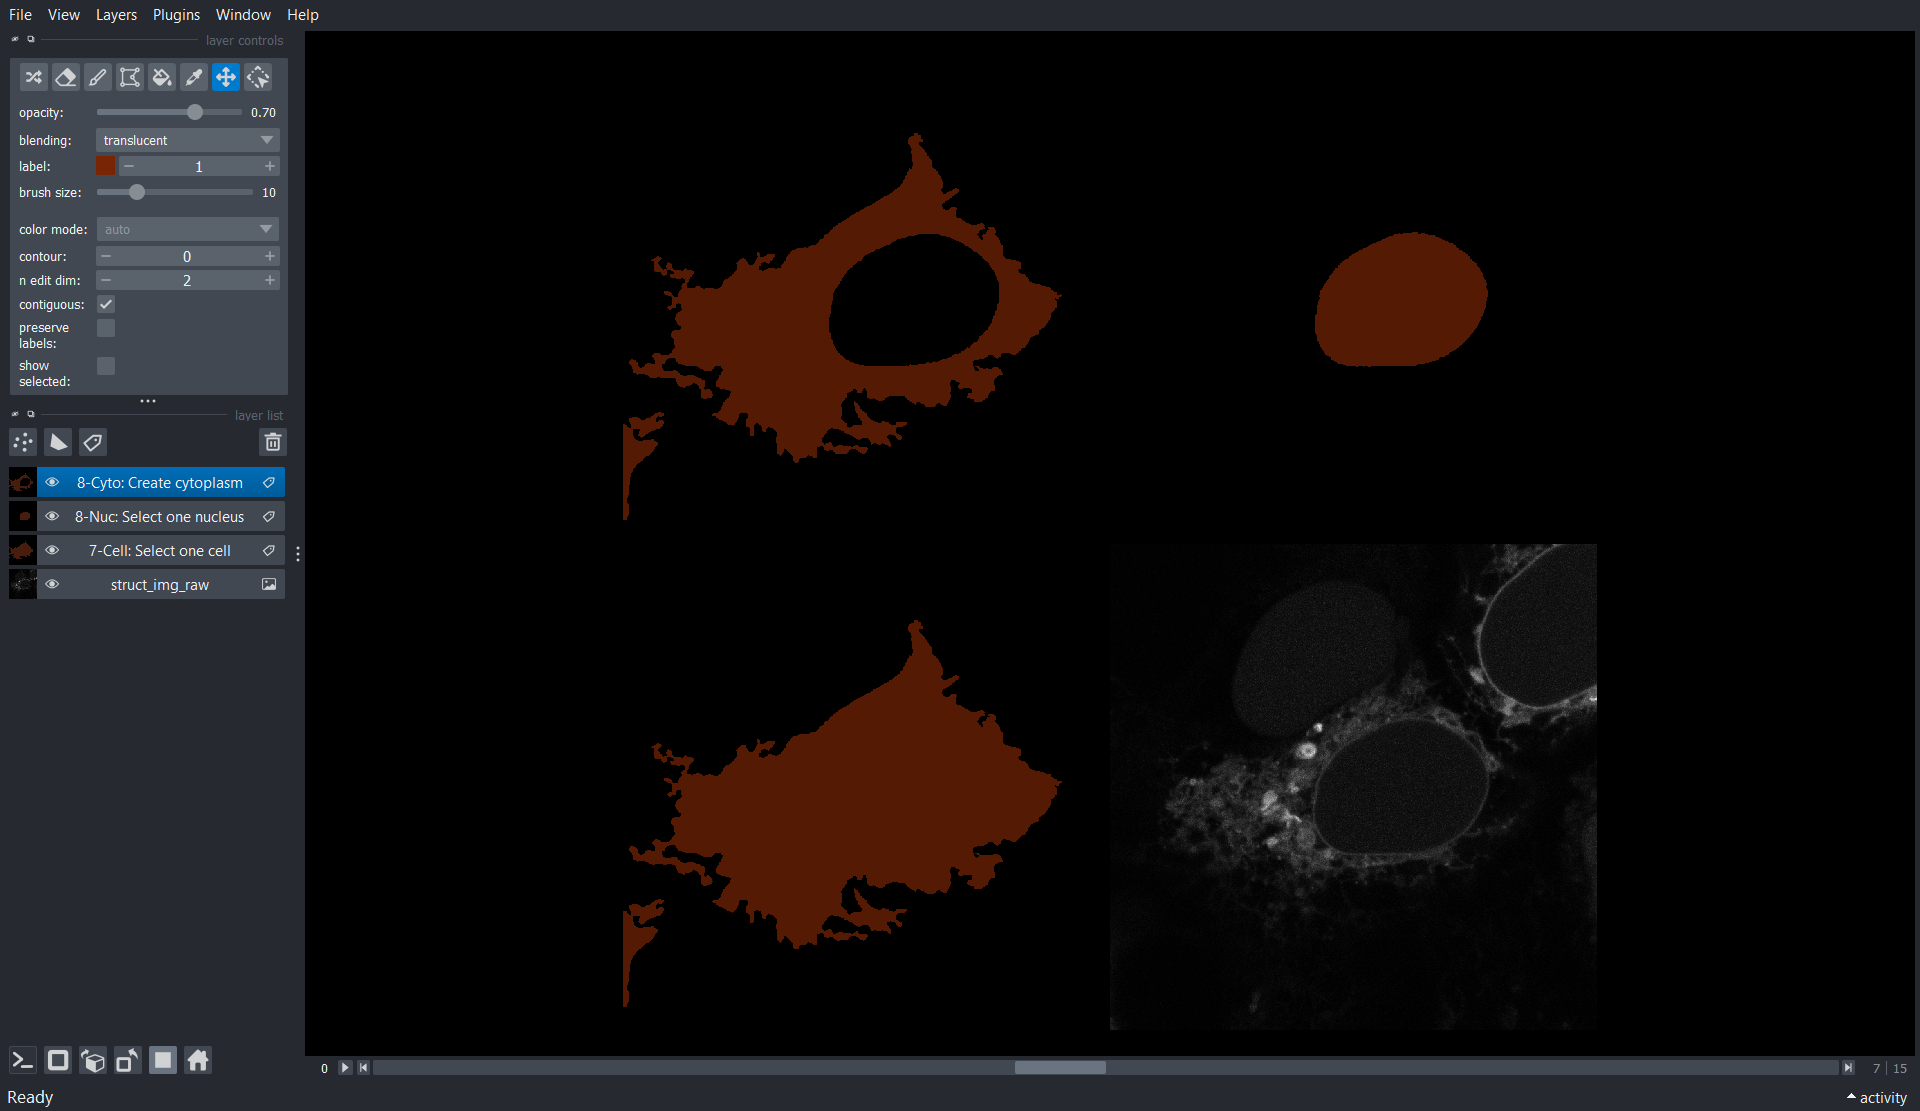

In [26]:
# mask the nuclei segmentation with the cellmask to select the single nucleus
nucleus_obj =  apply_mask(nuclei_labels, cellmask) 

# erode nucleus if desired (this likely depends on the type of label used)
nucleus_eroded = binary_erosion(nucleus_obj)

# select the cytoplasmic area (two ways shown here)
cyto_object = np.logical_and(cellmask,~nucleus_eroded)
cyto_object_xor = np.logical_xor(cellmask,nucleus_eroded)

nucleus_out = label_bool_as_uint16(nucleus_obj)
cytoplasm_out = label_bool_as_uint16(cyto_object_xor)

# adding image to Napari as a new layer
viewer.grid.enabled = True
viewer.add_labels(nucleus_out, scale=scale, name="8-Nuc: Select one nucleus")
viewer.add_labels(cytoplasm_out, scale=scale, name="8-Cyto: Create cytoplasm")
viewer.reset_view()

# screenshot viewer
nbscreenshot(viewer, canvas_only = False)

## **`STEP 9` - Stack masks**

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block stacks the single nucleus, cell, and cytoplasm masks into one multichannel image.

In [27]:
stack = stack_masks(nuc_mask=nucleus_out, cellmask=cellmask, cyto_mask=cytoplasm_out)

-----
## **SAVING**

## **`Saving` - Save the segmentation output**

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block saves the instance segmentation output to the `out_data_path` specified earlier.

In [28]:
out_file_n = export_inferred_organelle(stack, "masks", meta_dict, out_data_path)

saved file: a24hrs-Ctrl_10_Unmixing-masks


-----
-----
## **Define functions**
The following code includes an example of how the workflow steps above are combined into functions. The final combined `infer_masks` function can be run below to process a single image. It is included in the [batch process notebook](batch_process_segmentations.ipynb) to run the above analysis on multiple cells. 

This function can utilized from infer-subc using:
```python
infer_subc.organelles.masks.infer_masks()
```

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block defines the `infer_nuclei_fromlabel()`, function. It is applied below.

In [29]:
from infer_subc.organelles.cellmask import infer_cellmask_fromcomposite
from infer_subc.organelles.nuclei import infer_nuclei_fromlabel
from infer_subc.organelles.cytoplasm import infer_cytoplasm

In [ ]:
##########################
#  _infer_nuclei
##########################
def _infer_nuclei_fromlabel(in_img: np.ndarray, 
                            nuc_ch: Union[int,None],
                            median_sz: int, 
                            gauss_sig: float,
                            thresh_factor: float,
                            thresh_min: float,
                            thresh_max: float,
                            min_hole_w: int,
                            max_hole_w: int,
                            small_obj_w: int,
                            fill_filter_method: str
                            ) -> np.ndarray:
    """
    Procedure to infer nuclei from linear unmixed input.

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
    median_sz: int
        width of median filter for signal
    gauss_sig: float
        sigma for gaussian smoothing of  signal
    thresh_factor: float
        adjustment factor for log Li threholding
    thresh_min: float
        abs min threhold for log Li threholding
    thresh_max: float
        abs max threhold for log Li threholding
    max_hole_w: int
        hole filling cutoff for nuclei post-processing
    small_obj_w: int
        minimum object size cutoff for nuclei post-processing

    Returns
    -------------
    nuclei_object
        mask defined extent of NU
    
    """
    ###################
    # EXTRACT
    ###################                
    nuclei = select_channel_from_raw(in_img, nuc_ch)

    ###################
    # PRE_PROCESSING
    ###################                
    nuclei =  scale_and_smooth(nuclei,
                        median_size = median_sz, 
                        gauss_sigma = gauss_sig)

    ###################
    # CORE_PROCESSING
    ###################
    nuclei_object = apply_log_li_threshold(nuclei, 
                                           thresh_factor=thresh_factor, 
                                           thresh_min=thresh_min, 
                                           thresh_max=thresh_max)

    ###################
    # POST_PROCESSING
    ###################
    nuclei_object = fill_and_filter_linear_size(nuclei_object, 
                                                hole_min=min_hole_w, 
                                                hole_max=max_hole_w, 
                                                min_size=small_obj_w,
                                                method=fill_filter_method)

    nuclei_labels = label_uint16(nuclei_object)

    return nuclei_labels

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies the function above to your test image. The settings specified above are applied here.

In [31]:
# run nuclei segmentation from label
_NU_object = _infer_nuclei_fromlabel(img_data,
                                NUC_CH,
                                nuc_med_filter_size,
                                nuc_gaussian_smoothing_sigma,
                                nuc_threshold_factor,
                                nuc_thresh_min,
                                nuc_thresh_max,
                                nuc_hole_min_width,
                                nuc_hole_max_width,
                                nuc_small_object_width,
                                nuc_fill_filter_method)

# confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(nuclei_labels == _NU_object)}")

The segmentation output here matches the output created above: True


#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block defines the `infer_cellmask_fromcomposite()`, function. It is applied below.

In [ ]:
##########################
# infer_cellmask_fromaggr
##########################
def _infer_cellmask_fromcomposite(in_img: np.ndarray,
                                  weights: list[int],
                                  rescale: bool,
                                  nuclei_labels: np.ndarray,
                                  median_sz: int,
                                  gauss_sig: float,
                                  mo_method: str,
                                  mo_adjust: float,
                                  mo_cutoff_size: int,
                                  min_hole_w: int,
                                  max_hole_w: int,
                                  small_obj_w: int,
                                  fill_filter_method: str,
                                  watershed_method: str
                                  ) -> np.ndarray:
    """
    Procedure to infer cellmask from linear unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    weights:
        a list of int that corresond to the weights for each channel in the composite; use 0 if a channel should not be included in the composite image
    rescale:
        True - rescale composite image
        False - don't rescale composite image
    nuclei_labels: 
        a 3d image containing the inferred nuclei labels
    median_sz: 
        width of median filter for _cellmask_ signal
    gauss_sig: 
        sigma for gaussian smoothing of _cellmask_ signal
    mo_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    mo_adjust: 
        Masked Object threshold `local_adjust`
    mo_cutoff_size: 
        Masked Object threshold `size_min`
    max_hole_w: 
        hole filling cutoff for cellmask signal post-processing
    small_obj_w: 
        minimum object size cutoff for cellmask signal post-processing
    fill_filter_method:
        determines if the fill and filter function should be run 'sice-by-slice' or in '3D' 
    watershed_method:
        determines if the watershed should be run 'sice-by-slice' or in '3D' 

    Returns
    -------------
    cellmask_mask:
        a logical/labels object defining boundaries of cellmask

    """
    ###################
    # EXTRACT
    ###################
    struct_img = make_aggregate(in_img, *weights, rescale)

    ###################
    # PRE_PROCESSING
    ###################                         
    struct_img = scale_and_smooth(struct_img,
                                   median_size = median_sz, 
                                   gauss_sigma = gauss_sig)
    

    struct_img_non_lin = non_linear_cellmask_transform(struct_img)

    ###################
    # CORE_PROCESSING
    ###################
    struct_obj = masked_object_thresh(struct_img_non_lin, 
                                      global_method=mo_method, 
                                      cutoff_size=mo_cutoff_size, 
                                      local_adjust=mo_adjust)               

    ###################
    # POST_PROCESSING
    ###################
    struct_obj = fill_and_filter_linear_size(struct_obj, 
                                             hole_min=min_hole_w, 
                                             hole_max=max_hole_w, 
                                             min_size= small_obj_w,
                                             method=fill_filter_method)

    ###################
    # POST- POST_PROCESSING
    ###################
    cellmask_out = choose_max_label_cellmask_union_nucleus(struct_img, 
                                                           struct_obj, 
                                                           nuclei_labels, 
                                                           watershed_method=watershed_method) 

    return label_bool_as_uint16(cellmask_out)

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies the function above to your test image. The settings specified above are applied here.

In [34]:
# run cell mask segmentation from composite image
_CM_object = _infer_cellmask_fromcomposite(img_data,
                                            [w0, w1, w2, w3, w4, w5, w6, w7, w8, w9],
                                            rescale,
                                            nuclei_labels,
                                            med_filter_size,
                                            gaussian_smoothing_sigma,
                                            thresh_method,
                                            thresh_adj,
                                            cutoff_size,
                                            hole_min_width,
                                            hole_max_width,
                                            small_object_width,
                                            method,
                                            watershed_method)

#confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(cellmask == _CM_object)}")

The segmentation output here matches the output created above: True


#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block defines the `infer_cytoplasm()`, function. It is applied below.

In [36]:
def _infer_cytoplasm(nuclei_object, cellmask,  erode_nuclei = True):
    """
    Procedure to infer cytoplasm from linearly unmixed input.

    Parameters
    ------------
    nuclei_object: 
        a 3d image containing the nuclei signal
    cellmask: 
        a 3d image containing the cellmask signal
    erode_nuclei: 
        should we erode? Default False

    Returns
    -------------
    cytoplasm_mask 
        boolean np.ndarray
      
    """
    nucleus_obj =  apply_mask(nuclei_object, cellmask) 

    if erode_nuclei:
        cytoplasm_mask = np.logical_xor(cellmask, binary_erosion(nucleus_obj))
    else:
        cytoplasm_mask = np.logical_xor(cellmask, nucleus_obj)

    return label_bool_as_uint16(cytoplasm_mask)

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies the function above to your test image. The settings specified above are applied here.

In [37]:
_CY_object = _infer_cytoplasm(nuclei_labels, cellmask, erode_nuclei=True)

#confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(cytoplasm_out == _CY_object)}")

The segmentation output here matches the output created above: True


#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block defines the `infer_masks()`, function, the complete function that combines the three above and that will be used for batch processing. It is applied below.

In [ ]:
# Combined function for infering the masks
def _infer_masks(in_img: np.ndarray, 
                nuc_ch: Union[int,None],
                nuc_median_sz: int, 
                nuc_gauss_sig: float,
                nuc_thresh_factor: float,
                nuc_thresh_min: float,
                nuc_thresh_max: float,
                nuc_min_hole_w: int,
                nuc_max_hole_w: int,
                nuc_small_obj_w: int,
                nuc_fill_filter_method: str,
                cell_weights: list[int],
                cell_rescale: bool,
                cell_median_sz: int,
                cell_gauss_sig: float,
                cell_mo_method: str,
                cell_mo_adjust: float,
                cell_mo_cutoff_size: int,
                cell_min_hole_w: int,
                cell_max_hole_w: int,
                cell_small_obj_w: int,
                cell_fill_filter_method: str,
                cell_watershed_method: str,
                cyto_erode_nuclei = True
                
                ):
    """
    Procedure to infer nucleus, cellmask, and cytoplams from multichannel confocal microscopy input image.

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the organelle and nuclei label channels
    nuc_median_sz: int
        width of median filter for nuclei channel
    nuc_gauss_sig: float
        sigma for gaussian smoothing for nuclei channel
    nuc_thresh_factor: float
        adjustment factor for log Li threholding for nuclei channel
    nuc_thresh_min: float
        abs min threhold for log Li threholding for nuclei channel
    nuc_thresh_max: float
        abs max threhold for log Li threholding for nuclei channel
    nuc_max_hole_w: int
        hole filling cutoff for nuclei post-processing for nuclei channel
    nuc_small_obj_w: int
        minimum object size cutoff for nuclei post-processing for nuclei channel
    cell_weights:
        a list of int that corresond to the weights for each channel in the composite; use 0 if a channel should not be included in the composite image
    cell_rescale:
        True - rescale composite image
        False - don't rescale composite image
    cell_nuclei_labels: 
        a 3d image containing the inferred nuclei labels
    cell_median_sz: 
        width of median filter for _cellmask_ signal
    cell_gauss_sig: 
        sigma for gaussian smoothing of _cellmask_ signal
    cell_mo_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    cell_mo_adjust: 
        Masked Object threshold `local_adjust`
    cell_mo_cutoff_size: 
        Masked Object threshold `size_min`
    cell_max_hole_w: 
        hole filling cutoff for cellmask signal post-processing
    cell_small_obj_w: 
        minimum object size cutoff for cellmask signal post-processing
    cell_fill_filter_method:
        determines if the fill and filter function should be run 'sice-by-slice' or in '3D' 
    cell_watershed_method:
        determines if the watershed should be run 'sice-by-slice' or in '3D' 
    cyto_erode_nuclei: 
        should we erode? Default False
    
    Output
    ------
    stacked_masks: np.ndarray
        a multi-channel np.ndarry containing the nuclei, cell, and cytoplasm masks
    """

    ####################
    ### infer nuclei ###
    ####################
    nuc_objs = infer_nuclei_fromlabel(in_img,
                                      nuc_ch,
                                      nuc_median_sz,
                                      nuc_gauss_sig,
                                      nuc_thresh_factor,
                                      nuc_thresh_min, 
                                      nuc_thresh_max, 
                                      nuc_min_hole_w, 
                                      nuc_max_hole_w,
                                      nuc_small_obj_w, 
                                      nuc_fill_filter_method)
    
    ######################
    ### infer cellmask ###
    ######################
    cellmask_obj = infer_cellmask_fromcomposite(img_data,
                                                cell_weights,
                                                cell_rescale,
                                                nuc_objs,
                                                cell_median_sz,
                                                cell_gauss_sig,
                                                cell_mo_method,
                                                cell_mo_adjust,
                                                cell_mo_cutoff_size,
                                                cell_min_hole_w,
                                                cell_max_hole_w,
                                                cell_small_obj_w,
                                                cell_fill_filter_method,
                                                cell_watershed_method)

    ######################
    ### infer cellmask ###
    ###################### 
    cyto_obj = infer_cytoplasm(nuc_objs, 
                               cellmask_obj,
                               erode_nuclei=cyto_erode_nuclei)
    
    #########################
    ### select single nuc ###
    #########################
    nuc_obj = apply_mask(nuc_objs, cellmask_obj)
    nuc_obj = label_bool_as_uint16(nuc_obj)
    
    ###################
    ### stack masks ###
    ###################
    maskstack = stack_masks(nuc_mask=nuc_obj, 
                            cellmask=cellmask_obj,
                            cyto_mask=cyto_obj)
    
    return maskstack

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies the function above to your test image. The settings specified above are applied here.

In [43]:
# run nuclei segmentation from label
_stacked_masks = _infer_masks(img_data, 
                              NUC_CH,
                              nuc_med_filter_size,
                              nuc_gaussian_smoothing_sigma,
                              nuc_threshold_factor,
                              nuc_thresh_min,
                              nuc_thresh_max,
                              nuc_hole_min_width,
                              nuc_hole_max_width,
                              nuc_small_object_width,
                              nuc_fill_filter_method,
                              [w0, w1, w2, w3, w4, w5, w6, w7, w8, w9],
                              rescale,
                              med_filter_size,
                              gaussian_smoothing_sigma,
                              thresh_method,
                              thresh_adj,
                              cutoff_size,
                              hole_min_width,
                              hole_max_width,
                              small_object_width,
                              method,
                              watershed_method,
                              True)

#confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(stack == _stacked_masks)}")

The segmentation output here matches the output created above: True


-------------
### ✅ **INFER MASKS COMPLETE!**

Now that a single cell has been identified for analysis, the organelle segmentions need to be completed. Continue on to complete the organelle notebooks (1.2 through 1.7) associated to each of the organelles you would like to include in your analysis:
- Infer [`lysosomes`](1.2_infer_lysosome.ipynb)
- Infer [`mitochondria`](1.3_infer_mitochondria.ipynb)
- Infer [`golgi`](1.4_infer_golgi.ipynb)
- Infer [`peroxisomes`](1.5_infer_peroxisome.ipynb)
- Infer [`endoplasmic reticulum (ER)`](1.6_infer_ER.ipynb)
- Infer [`lipid droplets`](1.7_infer_lipid_droplet.ipynb)